<a href="https://colab.research.google.com/github/m-wessler/nbm-verification/blob/main/NBM_4_1_CWASP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NBM CWASP**
A little script to grab an NBM geotiff from AWS and plot CWASP and severe LSRs. Note the LSRs will cover a 24-h period centered on the chosen valid time.
-*Caleb Steele - NWS WR STID - 30-Mar-2022*

Feel free to steal or use as a springboard for you own endeavours. Contact me if you need help walking through it - caleb.steele@noaa.gov

First, run the cell below to import everything we need. It will take a minute or two to run


---



In [1]:
#!apt-get install libgeos-dev==3.7.2
import numpy as np
import os
from urllib.request import urlretrieve

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"


!pip install rioxarray
import rioxarray as rxr
import pandas as pd
import json
!pip install pyepsg
!pip install pyproj
from pyproj.crs import CRS

from datetime import datetime, timedelta
#!pip install --no-binary shapely shapely --force
#!pip install --no-binary cartopy cartopy
!pip uninstall shapely --yes
!pip install shapely cartopy==0.19.0.post1 --no-binary shapely --no-binary cartopy
!pip install cartopy
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
#!pip install contextily
#import contextily as cx

import warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 915.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 18.9 MB/s eta 0:00:00
Found existing installation: shapely 2.0.4
Uninstalling shapely-2.0.4:
  Successfully uninstalled shapely-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfu

The cell below has some config things to set. For the curious, you can unhide the code hiding underneath.

Making sense of inputs
https://noaa-nbm-pds.s3.amazonaws.com/blendv4.2/conus/2024/05/30/0000/cwasp/blendv4.2_conus_cwasp_2024-05-30T00:00_2024-06-01T00:00.tif
Getting NBM data
 > Got it! Max:  64
Making NBM CWASP plot
 > Initializing map
mkdir: cannot create directory ‘shp’: File exists
Aw shucks, no CWA boundaries for you. Sorry bout that.
 > Contouring NBM data
 > Getting LSRs
   >> Got 'em
   >> So plotted
 > Finshing up map
 > Saving plot as CONUS_cwasp.png
Done!


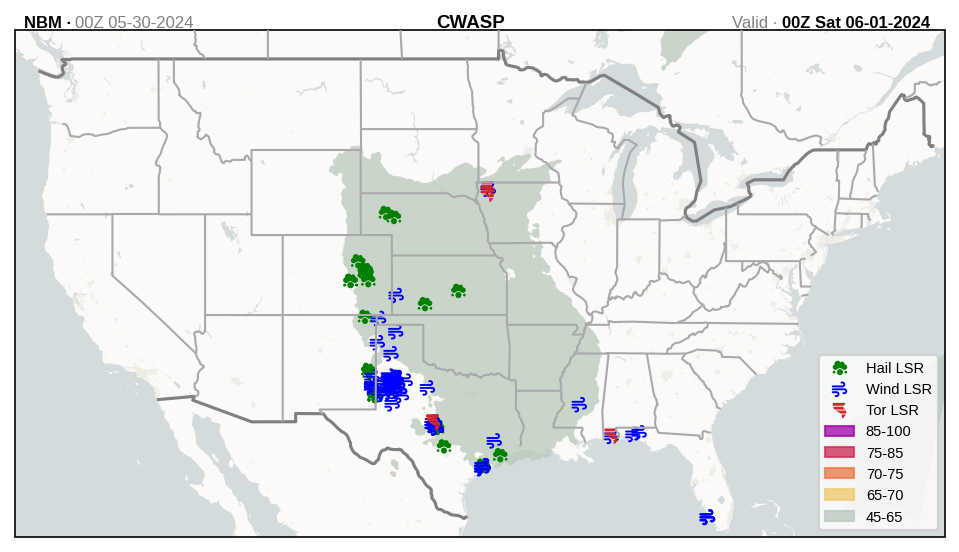

In [3]:
#@markdown Synoptic Token:
synoptic_token = "a2386b75ecbc4c2784db1270695dde73" #@param {type:'string'}

#@title Plot Config { vertical-output: true, display-mode: "form" }
var = "cwasp"
#@markdown Deterministic or Prob CWASP?
DPF = "Deterministic" #@param ["Deterministic","Probabilistic"]
#@markdown Threshold if you selected probabilistic
prob_threshold = "75" #@param ["50","65","70","75","85"]
#@markdown Choose Valid (ending) date/hour (UTC)
valid_date = "2024-06-01" #@param {type:"date"}
valid_hour = 0 #@param {type:"slider", min:0, max:18, step:6}
#@markdown Choose NBM initialization date/hour (UTC) (PWPF is every hour, but PQPF is only 00/12Z).
init_date = "2024-05-30" #@param {type:"date"}
init_hour = 0 #@param {type:"slider", min:0, max:23, step:1}
#vt = "2022-02-04T12:00" #@param {type:"string"}
#init = "2022-01-31T13:00" #@param {type:"string"}


#threshold = "025" #@param {type:"string"}
#@markdown Do you want to plot LSRs (past valid dates only)
tor_lsr_opt = True #@param {type:"boolean"}
hail_lsr_opt = True #@param {type:"boolean"}
wind_lsr_opt = True #@param {type:"boolean"}
cwa_outline = True #@param {type:"boolean"}
#@markdown Pick your domain or select custom and input custom lat/lon
dom = "CONUS" #@param ["CONUS","ECONUS","WR","SR","ER","CR","ut", "co", "midwest", "SWUS", "AZ","Custom"]
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_name = "" #@param {type:"string"}
custom_bottom_lat =  42.27#@param {type:"number"}
custom_left_lon = -97.44 #@param {type:"number"}
custom_top_lat = 49.42 #@param {type:"number"}
custom_right_lon = -87.13 #@param {type:"number"}

print("Making sense of inputs")

init_input = datetime.strptime(init_date,'%Y-%m-%d') + timedelta(hours=int(init_hour))
init = init_input.strftime('%Y-%m-%dT%H:%M')

valid_input = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=int(valid_hour))
vt = valid_input.strftime('%Y-%m-%dT%H:%M')

blend_ver = 'v4.1' if init_input < datetime(2024, 5, 16, 18, 0) else 'v4.2'

'''
##### Config settings below #####
forecast_length = "72" # For NBM v4.0, PQPF is only available for 24 hr lengths. However, PWPF is available in 24,48,72-hr
ptype = "ice" #snow, ice, or qpf
var = "prob" #prob or percentile
vt = "2022-02-04T12:00"
init = "2022-01-29T19:00" # Note: ProbQPF is only available at 6-hr/synoptic times, PWPF is availabe more frequenty
# threshold choices for percentile = 5, 10, 25, 50, 75, 90, 95
# theshold choices for prob snow = 001 (0.1"), 010 (1.0"), 020, 040, 060, 080, 120 (12.0"), 180, 240, 300
# theshold choices for prob qpf = 001 (0.01"), 010 (0.10"), 025 (0.25"), 050 (0.5"), 100 (1.00"), 200 (2.00"), 300 (3.00"), 400, 500, 600
threshold = "010"
dom = "TXNY" # choices in domain setions below
lsr_opt = True
'''
width = 8 # sets figure width value
height = 8 # sets figure height value
##### Initialize some global variables - probably don't edit these #####
def splittime(inputtimestring):
    dtlist = []
    inputdt = datetime.strptime(inputtimestring,'%Y-%m-%dT%H:%M')
    outyear = dtlist.append(inputdt.strftime('%Y'))
    outmonth = dtlist.append(inputdt.strftime('%m'))
    outday = dtlist.append(inputdt.strftime('%d'))
    outhour = dtlist.append(inputdt.strftime('%H'))
    return dtlist

maplayertext1, maplayertext2 = "",""
proj = ""
west = ""
south = ""
east = ""
north = ""
LLOC = ""
icon_dict={"hail":
              {"icon":"\uf73b","color":"green","label":"Hail LSR"},
           "wind":
              {"icon":"\uf72e","color":"blue","label":"Wind LSR"},
           "tornado":
              {"icon":"\uf76f","color":"tab:red","label":"Tor LSR"},
}

if (DPF =="Deterministic"):
  url_base = f"https://noaa-nbm-pds.s3.amazonaws.com/blend{blend_ver}/conus/"+splittime(init)[0]+"/"+splittime(init)[1]+"/"+splittime(init)[2]+"/"+splittime(init)[3]+"00/cwasp/"
  file = f"blend{blend_ver}_conus_cwasp_"+init+"_"+vt+".tif"
elif (DPF =="Probabilistic"):
  url_base = f"https://noaa-nbm-pds.s3.amazonaws.com/blend{blend_ver}/conus/"+splittime(init)[0]+"/"+splittime(init)[1]+"/"+splittime(init)[2]+"/"+splittime(init)[3]+"00/probcwaspgt0"+prob_threshold+"/"
  file = f"blend{blend_ver}_conus_probcwaspgt0"+prob_threshold+"_"+init+"_"+vt+".tif"
else:
  print(" ! > Not enough info to build URL")
url = url_base+file
print(url)

###########################################################################################################
print("Getting NBM data")
try:
  urlretrieve(url, file)
  tifdata = rxr.open_rasterio(file)
  x,y = (tifdata.coords['x'].values, tifdata.coords['y'].values)
  #print(tifdata)
  nbm = tifdata.values[0]
  #print(nbm.shape)
  print(" > Got it! Max: ", np.max(nbm))
  datacrs = ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25,25)) #Standard NBM projection, but probably better to read it from the file
  # Make the timestrings nice
  def timestring(modeltime):
      modeldt = datetime.strptime(modeltime,'%Y-%m-%dT%H:%M')
      outtime = '%s' % (modeldt.strftime('%HZ %a %m-%d-%Y'))
      return outtime

  def timestring2(modeltime):
      modeldt = datetime.strptime(modeltime,'%Y-%m-%dT%H:%M')
      outtime = '%s' % (modeldt.strftime('%HZ %m-%d-%Y'))
      return outtime

  initime = timestring2(str(init))
  CURTIMESTRING = timestring(str(vt))
except:
  print(" ! > Unable to get file")

########################################################################

### Define all the neat functions we we use ###
font_exists = os.path.exists("Font_Awesome_6_Free-Solid-900.otf")
if font_exists:
  pass
else:
  urlretrieve("https://www.dynamicmeteorology.com/style/Font_Awesome_6_Free-Solid-900.otf", "Font_Awesome_6_Free-Solid-900.otf")
fp = FontProperties(fname=r"Font_Awesome_6_Free-Solid-900.otf")

def get_marker(symbol):
    v, codes = TextToPath().get_text_path(fp, symbol)
    v = np.array(v)
    mean = np.mean([np.max(v,axis=0), np.min(v, axis=0)], axis=0)
    return Path(v-mean, codes, closed=False)

### set up the blank plot with mapstuffs
proj = ccrs.Mercator.GOOGLE
latloncrs = ccrs.PlateCarree()

def blankmap():
    global north, south, east, west, maplayertext1, maplayertext2, LLOC
    print(" > Initializing map")
    plt.figure(figsize=(width,height),frameon=True)
    F = plt.gcf()  # Gets the current figure
    ax = plt.axes(projection=proj)
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#FAFAF8', zorder=-2)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#D4DBDD', zorder=-2)
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#D4DBDD', zorder=-1)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey', facecolor='none', linewidth=1.5, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='darkgray', facecolor='none', linewidth=1.0, zorder=3))
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'urban_areas', '10m', edgecolor='none', facecolor='#eeeee6', linewidth=0.0, zorder=-1))
    if cwa_outline:
      try:
        if os.path.exists("shp/w_22mr22.shp"):
          pass
        else:
          cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
          !mkdir shp
          urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
          !unzip shp/nws_cwa_outlines.zip -d shp
        cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='none', linewidth=0.5, linestyle=':')
        ax.add_feature(cwa_feature)
      except:
        print("Aw shucks, no CWA boundaries for you. Sorry bout that.")

### Here is where you set up the domain.
### Want to add another? Just copy the last (elif) one and change the bounds (try to keep it square)
### Note the attributes are turned OFF on the cx.add_basemap layers IF you have mixed and matched provider sources. \
### This is because each attribution goes on top of the other, and thus are manually added so they remain legible.
    if (dom == "ut"):
        west = -116.1625
        south = 36.5530
        east = -107.1234
        north = 42.4958
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='gray', facecolor='none', linewidth=1.0, zorder=3))
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
        #cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "(C) Esri -- Source: USGS, Esri, TANA, DeLorme, and NPS" #for Esri,WorldTerrain
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerHybrid, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0 -- Map Data (C) OpenStreetMap contributors" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "co"):
        west = -109.2934
        south = 37.0186
        east = -101.8524
        north =41.3569
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
        #cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "(C) Esri -- Source: USGS, Esri, TANA, DeLorme, and NPS" #for Esri,WorldTerrain
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerHybrid, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0 -- Map Data (C) OpenStreetMap contributors" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C


    elif (dom == "midwest"):
        west = -99.24
        south = 34.35
        east = -79.40
        north = 47.35
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB" #for Esri,WorldTerrain
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False,zoom=6, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=6, alpha=0.5, crs=CRS.from_epsg(3857))
        maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C


    elif (dom == "SWUS"):
        west = -125.582
        south = 31.136
        east = -108.689
        north = 42.859
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB" #for Esri,WorldTerrain
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False,zoom=6, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=6, alpha=0.5, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 3 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "AZ"):
        west = -115.596
        south = 31.113
        east = -107.887
        north = 37.446
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "(C) Esri -- Source: USGS, Esri, TANA, DeLorme, and NPS" #for Esri,WorldTerrain
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerHybrid, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0 -- Map Data (C) OpenStreetMap contributors" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "ECONUS"):
        west = -104.36
        south = 24.735
        east = -66.453
        north = 49.755
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB" #for Esri,WorldTerrain
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=4, alpha=0.5, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "WR"):
        west = -126.917
        south = 30.586
        east = -102.740
        north = 49.755
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False)
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB"
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=5, alpha=0.5, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False, zoom=5, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "SR"):
        west = -109.758
        south = 23.313
        east = -78.247
        north = 37.899
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB"
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=5, alpha=0.5, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False, zoom=5, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 3 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "CR"):
        west = -111.534
        south = 35.118
        east = -80.723
        north = 49.755
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB"
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=5, alpha=0.5, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False, zoom=5, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "ER"):
        west = -85.629
        south = 31.723
        east = -66.465
        north = 47.676
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB"
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=5, alpha=0.5, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False, zoom=5, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "CONUS"):
        west = -126.269
        south = 24.791
        east = -66.439
        north = 50.209
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, crs=CRS.from_epsg(3857))
        #maplayertext1 = "Map tiles: (C) OpenStreetMap contributors (C) CartoDB"
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLines, attribution=False, zoom=5, alpha=0.5, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, attribution=False, zoom=5, crs=CRS.from_epsg(3857))
        #maplayertext2 = "Stamen Design CC BY, 3.0" #For Stamen.TonerHybrid
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    elif (dom == "Custom"):
        west = custom_left_lon
        south = custom_bottom_lat
        east = custom_right_lon
        north = custom_top_lat
        ax.set_extent([west, east, south, north], crs=latloncrs)
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, attribution=False, crs=CRS.from_epsg(3857))
        #cx.add_basemap(ax, source=cx.providers.Stamen.TonerHybrid, crs=CRS.from_epsg(3857))
        LLOC = 4 # 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

    else:
        print("Domain not defined! Add some code defining your domain!")

### Set up the plotting function (the thing that actually generates the finished figure)
def drawmap(DATA,TITLESTRING,PROD,UNITS,LEVS):
    global maplayertext1, maplayertext2
    print(" > Finshing up map")
    F = plt.gcf()  # Gets the current figure
    ax = plt.gca()  # Gets the current axes
    proxy = [mpatches.Patch(color = pc.get_facecolor()[0]) for pc in DATA.collections]
    LLABS = []
    for i in range(0, len(LEVS)-1):
      label = str(LEVS[i])+"-"+str(LEVS[i+1])+UNITS
      LLABS.append(label)

    if tor_lsr_opt:
      LLABS.append(icon_dict["tornado"]["label"])
      proxy.append(plt.scatter([], [], marker=get_marker(icon_dict["tornado"]["icon"]), color=icon_dict["tornado"]["color"], edgecolor='none', s=55,transform=proj))
    if wind_lsr_opt:
      LLABS.append(icon_dict["wind"]["label"])
      proxy.append(plt.scatter([], [], marker=get_marker(icon_dict["wind"]["icon"]), color=icon_dict["wind"]["color"], edgecolor='none', s=55,transform=proj))
    if hail_lsr_opt:
      LLABS.append(icon_dict["hail"]["label"])
      proxy.append(plt.scatter([], [], marker=get_marker(icon_dict["hail"]["icon"]), color=icon_dict["hail"]["color"], edgecolor='none', s=55,transform=proj))


    proxy = proxy[::-1]
    LLABS = LLABS[::-1]

    l = plt.legend(handles=proxy, labels=LLABS, fontsize='7',fancybox=True, loc=LLOC)
    l.set_zorder(100)

    #artists, labels = DATA.legend_elements()
    #plt.legend(handles=artists, labels=labels, title=UNITS, fontsize='8',title_fontsize=6,fancybox=True, loc=LLOC)
    plt.text(0.065,1.005, "NBM · ", transform = ax.transAxes,horizontalalignment='right',weight='bold',fontsize=8,color='k')
    plt.text(0.065,1.005, initime, transform = ax.transAxes,horizontalalignment='left',fontsize=8,color='grey')
    plt.text(0.49,1.005, TITLESTRING, transform = ax.transAxes,horizontalalignment='center',weight='bold',fontsize=9,color='k')
    plt.text(0.825,1.005,"Valid · ",transform = ax.transAxes,horizontalalignment='right',fontsize=8,color='grey')
    plt.text(0.825,1.005,CURTIMESTRING,transform = ax.transAxes,horizontalalignment='left',fontsize=8,weight='bold',color='k')
    if maplayertext1 != "":
      plt.text(0.005, 0.005, '%s // %s' % (maplayertext1,maplayertext2), transform = ax.transAxes,horizontalalignment='left',fontsize=6,color='k',path_effects=[PathEffects.withStroke(linewidth=1.4,foreground='w')], zorder=99)

    if dom=="Custom" and custom_name:
      custom_name_sanitized = custom_name.replace(" ","")
      file_id = '%s_%s' % (custom_name_sanitized, PROD)
    else:
      file_id = '%s_%s' % (dom, PROD)
    filename = '%s.png' % (file_id)
    print(f' > Saving plot as {filename}')
    plt.savefig(filename,bbox_inches='tight', facecolor="#FFFFFF") # Saves the figure with small margins
    print("Done!")
    plt.show()

    #plt.close()

# These set up how the plot looks like based on the variable you have chosen to plot.

### CWASP Plots ###
def plot_cwasp():
    print("Making NBM CWASP plot")
    blankmap()
    cwasp = nbm
    #gradient_radius = 20 # 2.5km*20 = 50km
    #cwasp_gradient_comps = np.gradient(cwasp)
    #cwasp_gradient = ( cwasp_gradient_comps[1]** 2 + cwasp_gradient_comps[0] ** 2) ** 0.5
    #print(cwasp_gradient)
    if (DPF =="Probabilistic"):
      title = f"Probability of CWASP > {prob_threshold}"
      prodid = f"probcwasp{prob_threshold}"
      units = r"%"
      CLEVS = [5,10,20,30,40,50,60,70,80,90,100]
      cwasp_plot = plt.contourf(x,y,cwasp,CLEVS,cmap=plt.get_cmap('hot_r'),extend='neither',alpha=0.75, transform=datacrs, antialiased = True)
    else:
      title = 'CWASP'
      prodid = 'cwasp'
      units = r""
      CWASP_SPC =["#F3F3F3", "#E1E1E1", "#CFCFCF", "#BDBDBD", "#ABABAB",
                    "#98E5B9", "#EEF569", "#CD781D", "#C90003", "#610091"]
      CWASP_SPC_trim =["#b9c9ba", "#f1c86a", "#ed7645", "#ce2754", "#9f00a6"]

      CLEVS = [45,65,70,75,85,100]
      print(" > Contouring NBM data")
      cwasp_plot = plt.contourf(x,y,cwasp,CLEVS,colors=CWASP_SPC_trim,extend='neither',alpha=0.75, transform=datacrs, antialiased = True)
      #cwasp_plot = plt.contourf(x,y,cwasp_gradient[0],CLEVS,cmap=plt.get_cmap('hot_r'),extend='neither',alpha=0.75, transform=datacrs, antialiased = True)
      #probsnow_plot = plt.contourf(x,y,probsnow,CLEVS,cmap=plt.get_cmap('BuPu'),extend='neither',alpha=0.75, transform=datacrs, antialiased = True)
      #uncomment the following lines if you want contours and labels
      #contours = plt.contour(x,y,probsnow,CLEVS,colors='silver',linewidths=1., alpha=0.35, transform=proj)
      #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors='k')
      #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground='w')])

    if any([tor_lsr_opt, hail_lsr_opt, wind_lsr_opt]):
      #lsr_lats, lsr_lons, lsr_mag = [], [], []
      lsr_start = datetime.strptime(vt,'%Y-%m-%dT%H:%M') - timedelta (hours=12)
      lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
      lsr_end = datetime.strptime(vt,'%Y-%m-%dT%H:%M') + timedelta (hours=12)
      lsr_end = lsr_end.strftime('%Y-%m-%dT%H:%M')
      lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
      csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

      print(" > Getting LSRs")
      try:
        file_exists = os.path.exists(csv_name)
        if file_exists:
          print("   >> Already got 'em")
        else:
          print("   >> Got 'em")
          urlretrieve(lsr_url, csv_name)

        LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
        LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
        LSRs['LAT'] = LSRs.LAT.astype(float)
        LSRs['LON'] = LSRs.LON.astype(float)
        #LSRs[(LSRs.TYPECODE=='5')&(LSRs.MAG>=0.1)].plot.scatter(x='LON', y='LAT', c='MAG', vmin=0, vmax=1, ec='red', s=100, transform=proj)
        LSRs_hail = LSRs[(LSRs.TYPECODE == 'H') & (LSRs.MAG >= 1)]
        hail_lats= LSRs_hail['LAT'].to_numpy()
        hail_lons= LSRs_hail['LON'].to_numpy()
        if hail_lsr_opt:
          plt.scatter(hail_lons, hail_lats, marker=get_marker(icon_dict["hail"]["icon"]), color=icon_dict["hail"]["color"], edgecolor='none', s=55,transform=latloncrs)

        LSRs_wind = LSRs[((LSRs.TYPECODE == 'G') & (LSRs.MAG >= 58)) | (LSRs.TYPECODE == 'D')]
        wind_lats= LSRs_wind['LAT'].to_numpy()
        wind_lons= LSRs_wind['LON'].to_numpy()

        if wind_lsr_opt:
          plt.scatter(wind_lons, wind_lats, marker=get_marker(icon_dict["wind"]["icon"]), color=icon_dict["wind"]["color"], edgecolor='none', s=55,transform=latloncrs)

        LSRs_tor = LSRs[(LSRs.TYPECODE == 'T')]
        tor_lats= LSRs_tor['LAT'].to_numpy()
        tor_lons= LSRs_tor['LON'].to_numpy()

        if tor_lsr_opt:
          plt.scatter(tor_lons, tor_lats, marker=get_marker(icon_dict["tornado"]["icon"]), color=icon_dict["tornado"]["color"], edgecolor='none', s=55,transform=latloncrs)

        print("   >> So plotted")

      except:
        print("   ! >> Uh oh! No LSRs for you")


    drawmap(cwasp_plot, title, prodid, units, CLEVS)

######################################################################################

matplotlib.rcParams['figure.dpi'] = 150 # make high quality figure - this never worked in the imports
plot_cwasp()

#https://noaa-nbm-pds.s3.amazonaws.com/blendv4.2/conus/2024/06/01/0000/cwasp/blendv4.2_conus_cwasp_2024-06-01T00%3A00_2024-06-01T01%3A00.tif
